## **Setup**

In [1]:
!pip install -q transformers
!pip install -q bitsandbytes
!pip install -q peft
!pip install -q torch
!pip install -q accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.7/174.7 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 16.3 MB/s eta 0:00:00


In [2]:
from transformers import TextDataset, DataCollatorForLanguageModeling
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from transformers import Trainer, TrainingArguments

import os
import torch
import torch.nn as nn
import bitsandbytes as bnb
import transformers
import peft

In [17]:
model = GPT2LMHeadModel.from_pretrained('gpt2')

In [4]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

## **LoRA Setup**

In [18]:
# We freeze the models weights by setting the requires_grad attribute to False.

for param in model.parameters():
  param.requires_grad = False
  if param.ndim == 1:
    param.data = param.data.to(torch.float32)

model.gradient_checkpointing_enable()
model.enable_input_require_grads()

class CastOutputToFloat(nn.Sequential):
  def forward(self, x): return super().forward(x).to(torch.float32)
model.lm_head = CastOutputToFloat(model.lm_head)

In [6]:
# Prints the number of trainable parameters in the model.

def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [19]:
# Setup LoRA Config using peft

from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=64,
    lora_alpha=128,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 2359296 || all params: 126799104 || trainable%: 1.8606566809809635


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/model.py:311: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


## **Data Loading and Tokenization**

In [8]:
data = []

with open("parsed_quotes_context.txt") as sherlock_quotes_file:
    lines = sherlock_quotes_file.readlines()
    for i in range(0, len(lines), 3):
        if i + 1 < len(lines):
            concatenated_lines = f"{lines[i].strip()} ->: {lines[i+1].strip()}"
            data.append(concatenated_lines)

In [9]:
len(data)

855

In [10]:
tokenizer.pad_token = tokenizer.eos_token

In [11]:
from sklearn.model_selection import train_test_split
train_data, val_data = train_test_split(data, test_size=0.2, random_state=50)

train_data = [tokenizer(line) for line in train_data]
val_data = [tokenizer(line) for line in val_data]

In [ ]:
# To instead load a pretrained model:

# model = GPT2LMHeadModel.from_pretrained("gpt2-sherlock-v0")

## **Training**

In [20]:
seed = 42
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

trainer = transformers.Trainer(
    model=model,
    train_dataset=train_data,
    eval_dataset=val_data,
    args=transformers.TrainingArguments(
        per_device_train_batch_size=4,
        gradient_accumulation_steps=4,
        warmup_steps=100,
        max_steps=1000,
        learning_rate=2e-4,
        fp16=True,
        logging_steps=1,
        evaluation_strategy="steps",
        eval_steps=20,
        output_dir='outputs',
        save_steps=250,
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
)
model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
20,4.507600,4.146500
40,4.338300,4.008358
60,3.914900,3.755986
80,3.723800,3.568017
100,3.640900,3.502892
120,3.442800,3.471408
140,3.508800,3.450394
160,3.451100,3.435556
180,3.562800,3.422349
200,3.353200,3.423194


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

TrainOutput(global_step=1000, training_loss=3.3798072917461397, metrics={'train_runtime': 425.9055, 'train_samples_per_second': 37.567, 'train_steps_per_second': 2.348, 'total_flos': 666167494533120.0, 'train_loss': 3.3798072917461397, 'epoch': 23.39})

## **Sampling**

In [29]:
from transformers import set_seed

set_seed(40)

device = model.device
batch = tokenizer("How would you find who committed the crime, Detective? ->: ", return_tensors='pt')
batch.to(device)

sample_outputs = model.generate(
    **batch,
    max_new_tokens=100,
    do_sample=True,
    top_k=50,
    top_p=0.95,
    num_return_sequences=1,
)

print("Output:\n" + 100 * '-')
for i, sample_output in enumerate(sample_outputs):
  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
0: How would you find who committed the crime, Detective? ->: _____ A man named John Dickson, of Dunbar. Perhaps I should think of him, Mrs. Moriarty. And the other man? If we've been caught already, is he still alive? What can he do for us? Is he still trying to sell his car? Or-- (CHUCKLES)... has he forgotten to pay his wife? She's probably still suffering from a cough that washes over the top of her nose. The woman who was in the house at the


In [ ]:
# To save the model

# model.save_pretrained("gpt2-sherlock-v0", from_pt=True)

## **Graphs and Visualizations**

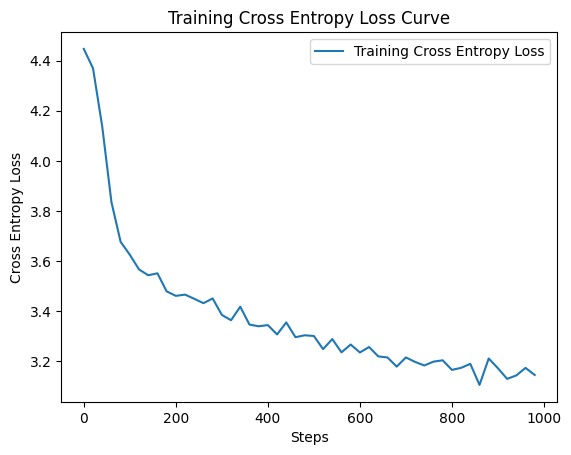

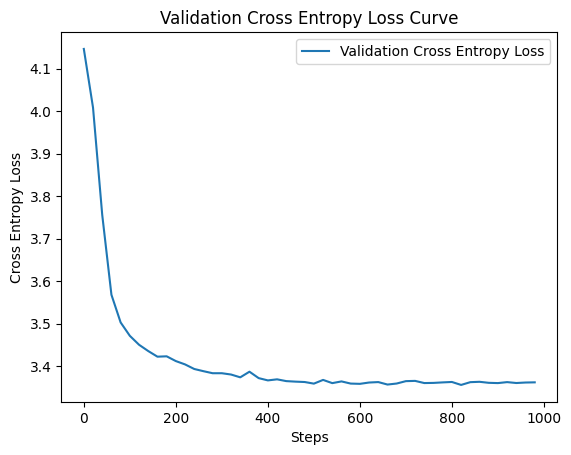

In [24]:
import matplotlib.pyplot as plt

train_loss_values = []
val_loss_values = []

# Access the training and val loss values from the Trainer's log
for i, x in enumerate(trainer.state.log_history[:-1]):
  if (i+1) % 21 == 0:
    val_loss_values.append(x["eval_loss"])
  else:
    train_loss_values.append(x["loss"])
train_loss_values = [sum(train_loss_values[i:i+20]) / 20 for i in range(0, len(train_loss_values), 20)]

# Plot the training loss curve
plt.plot(train_loss_values, label="Training Cross Entropy Loss")
plt.xlabel("Steps")
plt.xticks([0, 10, 20, 30, 40, 50], [0, 200, 400, 600, 800, 1000])
plt.ylabel("Cross Entropy Loss")
plt.title("Training Cross Entropy Loss Curve")
plt.legend()
plt.show()

# Plot the val loss curve
plt.plot(val_loss_values, label="Validation Cross Entropy Loss")
plt.xlabel("Steps")
plt.xticks([0, 10, 20, 30, 40, 50], [0, 200, 400, 600, 800, 1000])
plt.ylabel("Cross Entropy Loss")
plt.title("Validation Cross Entropy Loss Curve")
plt.legend()
plt.show()

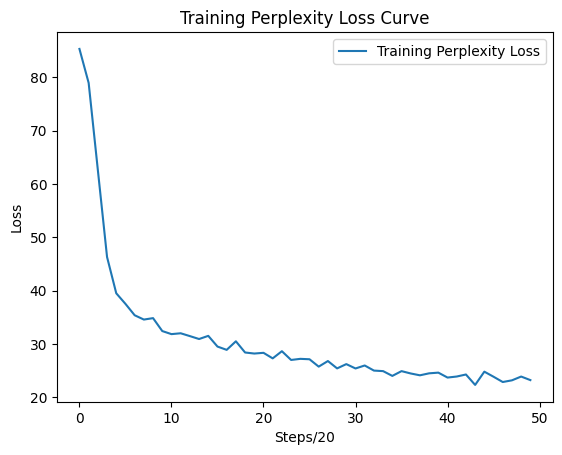

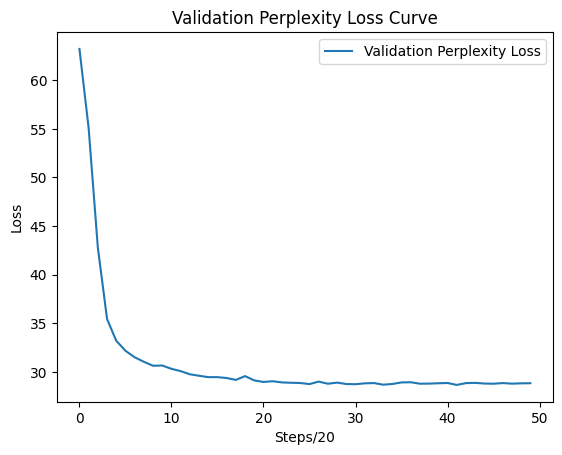

In [23]:
import numpy as np
perplexity_train_loss_values = [np.exp(x) for x in train_loss_values]
perplexity_val_loss_values = [np.exp(x) for x in val_loss_values]

# Plot the training loss curve
plt.plot(perplexity_train_loss_values, label="Training Perplexity Loss")
plt.xlabel("Steps/20")
plt.ylabel("Loss")
plt.title("Training Perplexity Loss Curve")
plt.legend()
plt.show()

# Plot the validation loss curve
plt.plot(perplexity_val_loss_values, label="Validation Perplexity Loss")
plt.xlabel("Steps/20")
plt.ylabel("Loss")
plt.title("Validation Perplexity Loss Curve")
plt.legend()
plt.show()

## **Checkpointed Sampling**

In [26]:
model_250 = GPT2LMHeadModel.from_pretrained("outputs/checkpoint-250")

set_seed(40)

device = model_250.device
batch = tokenizer("How can we find who robbed the house, Sherlock? ->: ", return_tensors='pt')
batch.to(device)

sample_outputs = model_250.generate(
    **batch,
    max_new_tokens=200,
    do_sample=True,
    top_k=50,
    top_p=0.95,
    num_return_sequences=1,
)

print("Output:\n" + 100 * '-')
for i, sample_output in enumerate(sample_outputs):
  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
0: How can we find who robbed the house, Sherlock? ->: -------------------------- What do you mean, Watson? What do you mean, "who robbed the house"? Is it because of a misunderstanding? Well, what is the truth of that? Well, let me tell you a bit more about it. We met in the street the night before. He was a good lad, but he was a poor man. And so we set off in search of an old man. A gentleman in his fifties was able to pass in to find out about his acquaintance. We discovered his name, and he is now in custody at the local county prison. The good news is that he has had no further trouble and we hope he will be released soon. I know him from the news. He has just given me his address. I hope I can find him some day, before I go to court. We'll know more of his life in a minute. We'll keep you in our thoughts here and there. The next morning at twelve o'clock you can


In [28]:
model_500 = GPT2LMHeadModel.from_pretrained("outputs/checkpoint-500")

set_seed(40)

device = model_500.device
batch = tokenizer("How can we find who robbed the house, Sherlock? ->: ", return_tensors='pt')
batch.to(device)

sample_outputs = model_500.generate(
    **batch,
    max_new_tokens=200,
    do_sample=True,
    top_k=50,
    top_p=0.95,
    num_return_sequences=1,
)

print("Output:\n" + 100 * '-')
for i, sample_output in enumerate(sample_outputs):
  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
0: How can we find who robbed the house, Sherlock? ->: -------------------------- What do you mean, Watson? What do you mean, Mr. Jackson, I came across a note lying on the table. The note--the note--is a letter from your grandfather. It says, "I have sent you for a few things today." And I've discovered it--it is a letter from your father. Well, it's a note written in French. Here's my first chance." But then it's a note written in English. Here's my second chance. We'll return the note to you within five days. It's a note written in French. The same way. And here's the second chance. It's a note written in English and it's from the letter "I," just so that you understand that I'm your mother, sir. I've just got enough of my papers and I know that I can write to you in your own handwriting. (REVERSES) If this letter was not addressed to your grandfather, I believe my


In [30]:
model_750 = GPT2LMHeadModel.from_pretrained("outputs/checkpoint-750")

set_seed(40)

device = model_750.device
batch = tokenizer("How can we find who robbed the house, Sherlock? ->: ", return_tensors='pt')
batch.to(device)

sample_outputs = model_750.generate(
    **batch,
    max_new_tokens=200,
    do_sample=True,
    top_k=50,
    top_p=0.95,
    num_return_sequences=1,
)

print("Output:\n" + 100 * '-')
for i, sample_output in enumerate(sample_outputs):
  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
0: How can we find who robbed the house, Sherlock? ->: -------------------------- What do you mean, Watson? What do you mean, Mr. Jackson, I came across a burglar who is still in custody. We came to find the thief trapped in his own bedroom. I'm not sure how this happened. It's been the most miserable day of my life. And I suppose there was a promise of a new one. You know that. I don't know what it was. But I suppose there was some sort of magic to it. Could I help you? I could ask you to look into the circumstances. It's really puzzling. And, uh-- And I-- And I've got this question from my friend that-- Oh-- (TO INT): No, I think I could be more specific, Watson. I'm afraid I can't get rid of this burglar without being the one to blame. I can assure you that it will help you solve the case. (TO JOY) The robber, in your great shoes, was a


In [31]:
model_0 = GPT2LMHeadModel.from_pretrained("gpt2")

set_seed(40)

device = model_0.device
batch = tokenizer("How can we find who robbed the house, Sherlock? ->: ", return_tensors='pt')
batch.to(device)

sample_outputs = model_0.generate(
    **batch,
    max_new_tokens=200,
    do_sample=True,
    top_k=50,
    top_p=0.95,
    num_return_sequences=1,
)

print("Output:\n" + 100 * '-')
for i, sample_output in enumerate(sample_outputs):
  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
0: How can we find who robbed the house, Sherlock? ->: ------------ It's possible that they are trying to sneak the thieves in, but we are uncertain how to solve that problem. I'm worried we can't find those culprits in time. If they have time, we can take them in in time. ->: ------------- It's possible to obtain a number in the past, but I suspect they know the number of our next thief. Then we can use any clues we have to solve our case. And even if it's the number of the last one, we can have more confidence. ->: ------------- But, that is, this whole time I'm not thinking about whether it's the last thief, or the last night, or the last weekend, but how long we'll be without the other one. I hope that all these people have some hope that they won't fall victim to the same trick again. The only one that won't. ->: ------- There's a certain feeling about getting used to seein